<!DOCTYPE html>
<html lang="en">
<head>
<meta charset="UTF-8">
<meta name="viewport" content="width=device-width, initial-scale=1.0">
<style>
  body {
    font-family: 'Poppins', sans-serif;
    background: linear-gradient(135deg, #081229, #0a1a40, #0f3057);
    color: #f0f6fc;
    margin: 0;
    padding: 0;
    line-height: 1.8;
  }

  .container {
    max-width: 900px;
    margin: 60px auto;
    background: rgba(255, 255, 255, 0.05);
    border-radius: 15px;
    padding: 40px;
    box-shadow: 0 0 20px rgba(0, 255, 255, 0.1);
  }

  h1 {
    text-align: center;
    color: #00ffff;
    text-shadow: 0 0 8px #00e6ac;
    margin-bottom: 20px;
  }

  h2 {
    color: #64ffda;
    border-left: 5px solid #00bfa5;
    padding-left: 10px;
    margin-top: 30px;
  }

  p {
    background: rgba(0, 255, 255, 0.05);
    border-left: 4px solid #00e6ac;
    padding: 15px 20px;
    border-radius: 8px;
    color: #e6faff;
  }

  ul {
    background: rgba(255, 255, 255, 0.03);
    padding: 20px;
    border-radius: 10px;
    list-style-type: none;
  }

  ul li {
    background: rgba(0, 230, 172, 0.1);
    margin: 8px 0;
    padding: 10px 15px;
    border-left: 5px solid #00e6ac;
    border-radius: 5px;
    color: #b2fefa;
  }

  ul li:hover {
    background: rgba(0, 230, 172, 0.2);
    transform: translateX(5px);
    transition: 0.2s;
  }

  a {
    color: #58a6ff;
    text-decoration: none;
    font-weight: bold;
  }

  a:hover {
    color: #00e6ac;
    text-decoration: underline;
  }

  .footer {
    text-align: center;
    margin-top: 30px;
    padding: 15px;
    background: rgba(255, 255, 255, 0.03);
    border-radius: 10px;
  }

  .footer a {
    background-color: #00e6ac;
    color: #000;
    padding: 10px 20px;
    border-radius: 8px;
    text-decoration: none;
    font-weight: bold;
  }

  .footer a:hover {
    background-color: #00bfa5;
  }
</style>
</head>

<body>
<div class="container">
  <h2>📘 About the Data</h2>
  <p>
    The dataset contains <b>Gaussian filtered retina scan images</b> used for detecting 
    <b>Diabetic Retinopathy (DR)</b>.  
    These images are sourced from the <a href="https://www.kaggle.com/c/aptos2019-blindness-detection" target="_blank">APTOS 2019 Blindness Detection</a> dataset.  
    Each image has been <b>resized to 224x224 pixels</b> — making it compatible with most 
    <b>pre-trained deep learning models</b> such as ResNet, EfficientNet.
  </p>

  <p>
    All images are organized into folders based on the severity level of DR, following 
    the <code>train.csv</code> mapping provided with the dataset.
  </p>

  <h2>🗂️ Directory Structure</h2>
  <ul>
    <li>0 — <b>No_DR</b> (Healthy Eye)</li>
    <li>1 — <b>Mild</b> (Early signs of DR)</li>
    <li>2 — <b>Moderate</b> (Visible blood vessel damage)</li>
    <li>3 — <b>Severe</b> (Extensive retinal lesions)</li>
    <li>4 — <b>Proliferate_DR</b> (Advanced stage with abnormal vessel growth)</li>
  </ul>
</div>
</body>
</html>


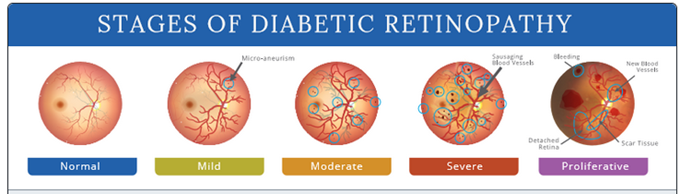

![](https://ai2-s2-public.s3.amazonaws.com/figures/2017-08-08/4e2ccbd15cc04a08c9a096424043c4aee7c4388b/2-Figure1-1.png)

In [1]:
from tensorflow import lite
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import random, os
import shutil
import matplotlib.pyplot as plt
from matplotlib.image import imread
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import categorical_accuracy
from sklearn.model_selection import train_test_split

2025-10-22 04:17:37.754220: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761106658.292379      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761106658.430484      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Add an additional column, mapping to the type
df = pd.read_csv(r'../input/diabetic-retinopathy-224x224-gaussian-filtered/train.csv')

diagnosis_dict_binary = {
    0: 'No_DR',
    1: 'DR',
    2: 'DR',
    3: 'DR',
    4: 'DR'
}

diagnosis_dict = {
    0: 'No_DR',
    1: 'Mild',
    2: 'Moderate',
    3: 'Severe',
    4: 'Proliferate_DR',
}


df['binary_type'] =  df['diagnosis'].map(diagnosis_dict_binary.get)
df['type'] = df['diagnosis'].map(diagnosis_dict.get)
df.head()

,id_code,diagnosis,binary_type,type
0,000c1434d8d7,2,DR,Moderate
1,001639a390f0,4,DR,Proliferate_DR
2,0024cdab0c1e,1,DR,Mild
3,002c21358ce6,0,No_DR,No_DR
4,005b95c28852,0,No_DR,No_DR


In [3]:
# Split into stratified train, val, and test sets
train_intermediate, val = train_test_split(df, test_size = 0.15, stratify = df['type'])
train, test = train_test_split(train_intermediate, test_size = 0.15 / (1 - 0.15), stratify = train_intermediate['type'])

print(train['type'].value_counts(), '\n')
print(test['type'].value_counts(), '\n')
print(val['type'].value_counts(), '\n')


type
No_DR             1263
Moderate           699
Mild               258
Proliferate_DR     207
Severe             135
Name: count, dtype: int64 

type
No_DR             271
Moderate          150
Mild               56
Proliferate_DR     44
Severe             29
Name: count, dtype: int64 

type
No_DR             271
Moderate          150
Mild               56
Proliferate_DR     44
Severe             29
Name: count, dtype: int64 



In [4]:
# Create working directories for train/val/test
base_dir = ''

train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

if os.path.exists(base_dir):
    shutil.rmtree(base_dir)

if os.path.exists(train_dir):
    shutil.rmtree(train_dir)
os.makedirs(train_dir)

if os.path.exists(val_dir):
    shutil.rmtree(val_dir)
os.makedirs(val_dir)

if os.path.exists(test_dir):
    shutil.rmtree(test_dir)
os.makedirs(test_dir)


In [5]:
# Copy images to respective working directory
src_dir = r'../input/diabetic-retinopathy-224x224-gaussian-filtered/gaussian_filtered_images/gaussian_filtered_images'
for index, row in train.iterrows():
    diagnosis = row['type']
    binary_diagnosis = row['binary_type']
    id_code = row['id_code'] + ".png"
    srcfile = os.path.join(src_dir, diagnosis, id_code)
    dstfile = os.path.join(train_dir, binary_diagnosis)
    os.makedirs(dstfile, exist_ok = True)
    shutil.copy(srcfile, dstfile)

for index, row in val.iterrows():
    diagnosis = row['type']
    binary_diagnosis = row['binary_type']
    id_code = row['id_code'] + ".png"
    srcfile = os.path.join(src_dir, diagnosis, id_code)
    dstfile = os.path.join(val_dir, binary_diagnosis)
    os.makedirs(dstfile, exist_ok = True)
    shutil.copy(srcfile, dstfile)
 
for index, row in test.iterrows():
    diagnosis = row['type']
    binary_diagnosis = row['binary_type']
    id_code = row['id_code'] + ".png"
    srcfile = os.path.join(src_dir, diagnosis, id_code)
    dstfile = os.path.join(test_dir, binary_diagnosis)
    os.makedirs(dstfile, exist_ok = True)
    shutil.copy(srcfile, dstfile)


In [6]:
# Setting up ImageDataGenerator for train/val/test 

train_path = 'train'
val_path = 'val'
test_path = 'test'

train_batches = ImageDataGenerator(rescale = 1./255).flow_from_directory(train_path, target_size=(224,224), shuffle = True)
val_batches = ImageDataGenerator(rescale = 1./255).flow_from_directory(val_path, target_size=(224,224), shuffle = True)
test_batches = ImageDataGenerator(rescale = 1./255).flow_from_directory(test_path, target_size=(224,224), shuffle = False)


Found 2562 images belonging to 2 classes.
Found 550 images belonging to 2 classes.
Found 550 images belonging to 2 classes.


In [7]:
# Building the model

model = tf.keras.Sequential([
    layers.Conv2D(8, (3,3), padding="valid", input_shape=(224,224,3), activation = 'relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.BatchNormalization(),
    
    layers.Conv2D(16, (3,3), padding="valid", activation = 'relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.BatchNormalization(),
    
    layers.Conv2D(32, (4,4), padding="valid", activation = 'relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.BatchNormalization(),
 
    layers.Flatten(),
    layers.Dense(32, activation = 'relu'),
    layers.Dropout(0.15),
    layers.Dense(2, activation = 'softmax')
])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1761106709.657040      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1761106709.657788      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [8]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-5),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['acc'])

history = model.fit(train_batches,
                    epochs=30,
                    validation_data=val_batches)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30


I0000 00:00:1761106715.804529      81 service.cc:148] XLA service 0x7a1f1c1068d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1761106715.806350      81 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1761106715.806373      81 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1761106716.371727      81 cuda_dnn.cc:529] Loaded cuDNN version 90300


 3/81 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - acc: 0.4184 - loss: 1.0819  

I0000 00:00:1761106721.287590      81 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


81/81 ━━━━━━━━━━━━━━━━━━━━ 21s 149ms/step - acc: 0.6902 - loss: 0.6437 - val_acc: 0.5073 - val_loss: 0.6922
Epoch 2/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 7s 87ms/step - acc: 0.8825 - loss: 0.3003 - val_acc: 0.5073 - val_loss: 0.7092
Epoch 3/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 7s 90ms/step - acc: 0.8988 - loss: 0.2696 - val_acc: 0.5945 - val_loss: 0.6091
Epoch 4/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 7s 89ms/step - acc: 0.9165 - loss: 0.2381 - val_acc: 0.6855 - val_loss: 0.4951
Epoch 5/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 7s 88ms/step - acc: 0.9227 - loss: 0.2283 - val_acc: 0.8673 - val_loss: 0.3719
Epoch 6/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 7s 89ms/step - acc: 0.9395 - loss: 0.2008 - val_acc: 0.9127 - val_loss: 0.2659
Epoch 7/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 7s 86ms/step - acc: 0.9457 - loss: 0.1885 - val_acc: 0.9164 - val_loss: 0.2279
Epoch 8/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 7s 88ms/step - acc: 0.9427 - loss: 0.1811 - val_acc: 0.9127 - val_loss: 0.2104
Epoch 9/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 7s 89ms/step - acc: 0.9335 - loss: 

In [9]:
model.save("final-CNN.h5")


In [10]:
loss, acc = model.evaluate(test_batches, verbose=1)
print("Accuracy:", acc)
# print("Loss: ", loss)


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - acc: 0.9560 - loss: 0.1412
Accuracy: 0.9581817984580994


# ****Diabet Retinopathy Detection Section****

In [11]:
import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt


def predict_class(path):
    img = cv2.imread(path)

    RGBImg = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    RGBImg= cv2.resize(RGBImg,(224,224))
    plt.imshow(RGBImg)
    image = np.array(RGBImg) / 255.0
    new_model = tf.keras.models.load_model("final-CNN.h5")
    predict=new_model.predict(np.array([image]))
    per=np.argmax(predict,axis=1)
    if per==1:
        print('No DR')
    else:
        print('DR')
    

    

## Check the model 1- proliferate 

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 839ms/step
DR


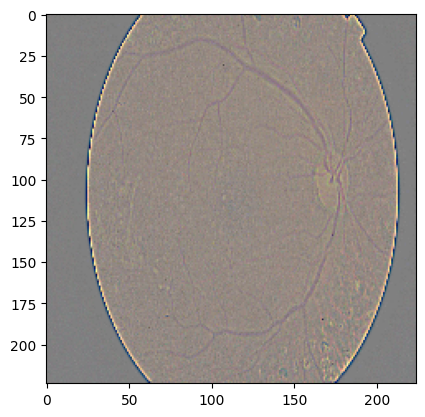

In [12]:
predict_class('/kaggle/input/diabetic-retinopathy-224x224-gaussian-filtered/gaussian_filtered_images/gaussian_filtered_images/Proliferate_DR/001639a390f0.png')

## 2- moderate

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 531ms/step
No DR


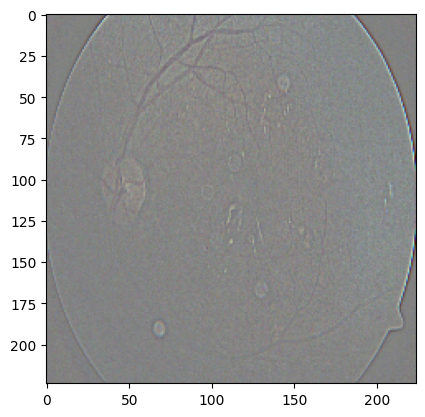

In [13]:
predict_class('/kaggle/input/diabetic-retinopathy-224x224-gaussian-filtered/gaussian_filtered_images/gaussian_filtered_images/Moderate/00b74780d31d.png')

## 3- Mild

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step
DR


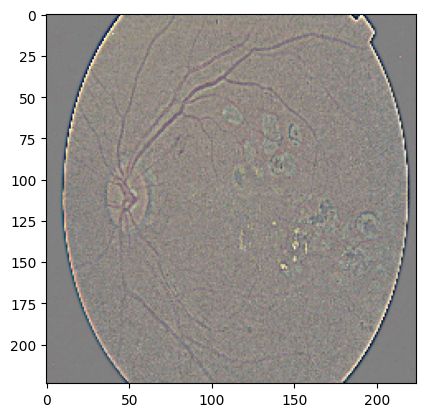

In [14]:
predict_class('/kaggle/input/diabetic-retinopathy-224x224-gaussian-filtered/gaussian_filtered_images/gaussian_filtered_images/Mild/059bc89df7f4.png')

## 4- Servere

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 550ms/step
DR


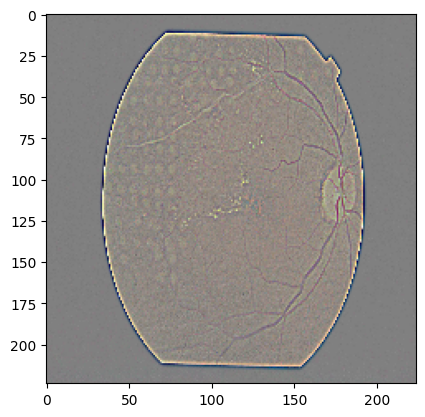

In [15]:
predict_class('/kaggle/input/diabetic-retinopathy-224x224-gaussian-filtered/gaussian_filtered_images/gaussian_filtered_images/Severe/2665f72e2dd3.png')